# Flow of a Stokes fluid in a Poisseuille channel

problem specification
$$
\begin{cases}
\Omega = [0, L_x] \times [0, L_y] \\
\textbf{u}_{\text{E}}(x,y=L_y)=\textbf{0} & \text{no-slip and no-penetration on upper and lower boundaries} \\
\textbf{u}_{\text{E}}(x,y=0)=\textbf{0} \\
\boldsymbol{\tau}_{\text{N}}(x=0,y)=p_{\text{in}}\textbf{e}_x & \text{equivalent to } p(x=0,y)=p_{\text{in}}\\ 
\boldsymbol{\tau}_{\text{N}}(x=L_x,y)=\textbf{0} & \text{equivalent to } p(x=L_x,y)=0\\ 
\end{cases}
$$

In [ ]:
from ufl import grad
from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import Function, Constant
from lucifex.solver import bvp, BoundaryConditions, OptionsPETSc
from lucifex.utils import cross_section, get_component_functions
from lucifex.viz import plot_colormap, plot_line
from lucifex.io import write, get_ipynb_file_name
from lucifex.pde.stokes import stokes_incompressible


Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 200, 200, 'right')
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "lower": lambda x: x[1],
        "upper": lambda x: x[1] - Ly,
    },
)
mu = Constant(mesh, 1.0, 'mu')
stress = lambda u: mu * grad(u)

u_elem = ('P', 2, 2)
p_elem = ('P', 1)
u_p_elem = [u_elem, p_elem]
up = Function((mesh, u_p_elem), name="up")

bcs_e = BoundaryConditions(
    ('essential', boundary['upper', 'lower'], (0.0, 0.0), 0),
)
p_in = 1.0
bcs_n = BoundaryConditions(
    ('natural', boundary['left'], (p_in, 0.0), 1),
    ('natural', boundary['right'], (0.0, 0.0), 1),
)

petsc = OptionsPETSc(pc_type='lu')
petsc['pc_factor_mat_solver_type'] = 'mumps'
up_solver = bvp(stokes_incompressible, bcs_e, petsc)(up, stress, bcs=bcs_n)
up_solver.solve()

u, p = up.split(('u', 'p'), collapse=True)
ux, uy = get_component_functions(('P', 1), u, names=('ux', 'uy'))

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$y$', ylabel='$u_x(x=1.00)$'>)

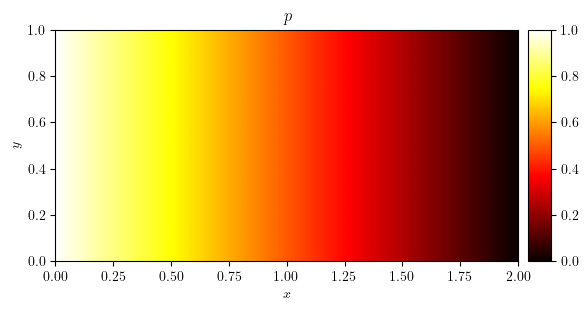

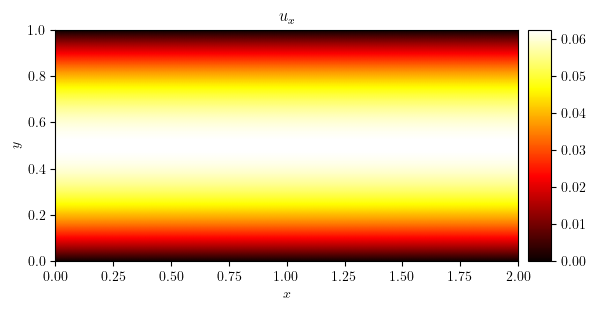

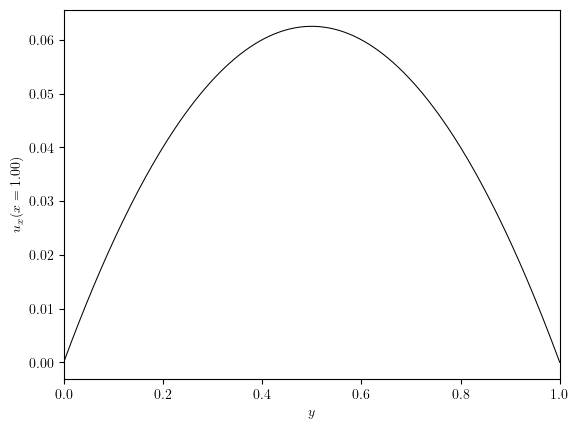

: 

In [ ]:
fig, ax = plot_colormap(p, title=f'${p.name}$')
write(fig, f'{get_ipynb_file_name()}_p', './figures', close=False, pickle=False)

fig, ax = plot_colormap(ux, title=f'${u.name}_x$')
write(fig, f'{get_ipynb_file_name()}_ux', './figures', close=False, pickle=False)

x_axis, ux_x, y_value = cross_section(ux, 'x', 0.5)
plot_line((x_axis, ux_x), x_label='$y$', y_label=f'${u.name}_x(x={y_value:.2f})$')